In [1]:
import os
import wfdb
import numpy as np
import matplotlib.pyplot as plt
import pywt
from collections import Counter
from scipy.signal import butter, filtfilt, find_peaks, resample
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks


In [2]:
data_folder = r"C:\Users\risha\Downloads\mit-bih-arrhythmia-database-1.0.0\mit-bih-arrhythmia-database-1.0.0"
fs = 360                      
pre_sec = 0.2              
post_sec = 0.4             
beat_len = int((pre_sec + post_sec) * fs)  
wavelet_name = 'db4'
augment_per_beat = 2       
USE_PCA = True               
pca_variance = 0.95
test_size = 0.2
random_state = 42
cnn_epochs = 30
cnn_batch = 64

In [3]:
def bandpass_filter(sig, low=0.5, high=40, fs=360, order=4):
    nyq = 0.5 * fs
    l = low / nyq
    h = high / nyq
    b, a = butter(order, [l, h], btype='band')
    return filtfilt(b, a, sig)

def wavelet_denoise(sig, wavelet='db4', level=3):
    coeffs = pywt.wavedec(sig, wavelet, level=level)
    sigma = np.median(np.abs(coeffs[-1])) / 0.6745
    uthresh = sigma * np.sqrt(2 * np.log(max(1, len(sig))))
    den = coeffs[:]
    den[1:] = [pywt.threshold(c, uthresh, mode='soft') for c in den[1:]]
    rec = pywt.waverec(den, wavelet)
    # match length
    if len(rec) > len(sig):
        rec = rec[:len(sig)]
    elif len(rec) < len(sig):
        rec = np.pad(rec, (0, len(sig) - len(rec)))
    return rec

def detect_r_peaks(sig, fs=360, distance_sec=0.2):
    s = (sig - np.mean(sig)) / (np.std(sig) + 1e-8)
    distance = int(distance_sec * fs)
    peaks, _ = find_peaks(s, distance=distance, height=np.mean(s) + 0.3*np.std(s))
    return peaks

def extract_beat(sig, r_idx, pre=pre_sec, post=post_sec, fs=360):
    pre_s = int(pre * fs)
    post_s = int(post * fs)
    start = r_idx - pre_s
    end = r_idx + post_s
    if start < 0 or end > len(sig):
        return None
    beat = sig[start:end].astype(float)
    beat = (beat - np.mean(beat)) / (np.std(beat) + 1e-8)
    return beat

def nearest_annotation_label(r_sample, ann, fs=360, tol_sec=0.25):
    if not hasattr(ann, 'sample') or len(ann.sample) == 0:
        return None
    idx = np.searchsorted(ann.sample, r_sample)
    candidates = []
    if idx < len(ann.sample):
        candidates.append(idx)
    if idx - 1 >= 0:
        candidates.append(idx - 1)
    best = None
    best_dist = 1e9
    for c in candidates:
        d = abs(int(ann.sample[c]) - int(r_sample))
        if d < best_dist:
            best_dist = d
            best = c
    if best is None:
        return None
    if best_dist > tol_sec * fs:
        return None
    symbol = ann.symbol[best]
    return 0 if symbol == 'N' else 1

def wavelet_features(beat, wavelet=wavelet_name, level=3):
    coeffs = pywt.wavedec(beat, wavelet, level=level)
    feats = []
    for c in coeffs:
        feats.extend([np.mean(c), np.std(c), np.max(c), np.min(c)])
    return np.array(feats)

def rr_features(peaks):
    if len(peaks) < 2:
        return np.array([0.0,0.0,0.0,0.0])
    rr = np.diff(peaks) / fs
    return np.array([np.mean(rr), np.std(rr), np.min(rr), np.max(rr)])

# Augmentation helpers
def augment_amplitude_noise(beat, amp_range=(0.9, 1.1), noise_std=0.01):
    if beat is None:
        return None
    beat = np.asarray(beat)
    scale = np.random.uniform(*amp_range)
    noise = np.random.normal(0, noise_std, size=beat.shape)
    return beat * scale + noise

def augment_time_stretch(beat, stretch_range=(0.95, 1.05)):
    if beat is None:
        return None
    fac = np.random.uniform(*stretch_range)
    new_len = int(len(beat) * fac)
    if new_len <= 1:
        return beat
    stretched = resample(beat, new_len)
    if len(stretched) > len(beat):
        stretched = stretched[:len(beat)]
    else:
        stretched = np.pad(stretched, (0, len(beat)-len(stretched)), 'constant')
    return stretched

def augment_beat(beat):
    if beat is None:
        return None
    b = augment_amplitude_noise(beat)
    b = augment_time_stretch(b)
    b = (b - np.mean(b)) / (np.std(b) + 1e-8)
    return b

In [4]:
beats = []
labels = []  
feature_matrix = [] 
feature_labels = []

files = sorted([f for f in os.listdir(data_folder) if f.endswith('.dat')])
if len(files) == 0:
    raise RuntimeError(f"No .dat files found in {data_folder} — set correct data_folder path")

print(f"Found {len(files)} files. Processing records... (this can take a few minutes)")

for f in files:
    rec = f.split('.')[0]
    rec_path = os.path.join(data_folder, rec)
    try:
        record = wfdb.rdrecord(rec_path)
        ann = wfdb.rdann(rec_path, 'atr')
        raw = record.p_signal[:, 0].astype(float)


        try:
            sig = bandpass_filter(raw, low=0.5, high=40, fs=fs, order=4)
        except Exception:
            sig = raw
        try:
            sig = wavelet_denoise(sig, wavelet=wavelet_name, level=3)
        except Exception:
            pass

        peaks = detect_r_peaks(sig, fs=fs, distance_sec=0.2)
        if len(peaks) == 0:
            continue

        rr_feats = rr_features(peaks)

        for r in peaks:
            beat = extract_beat(sig, r, pre=pre_sec, post=post_sec, fs=fs)
            if beat is None or len(beat) != beat_len:
                continue
            lbl = nearest_annotation_label(r, ann, fs=fs, tol_sec=0.25)
            if lbl is None:
                continue

            beats.append(beat.copy())
            labels.append(lbl)
            wf = wavelet_features(beat)
            feature_matrix.append(np.concatenate([wf, rr_feats]))
            feature_labels.append(lbl)


            for _ in range(augment_per_beat):
                aug = augment_beat(beat)
                if aug is None:
                    continue
                beats.append(aug.copy())
                labels.append(lbl)
                wf2 = wavelet_features(aug)
                feature_matrix.append(np.concatenate([wf2, rr_feats]))
                feature_labels.append(lbl)

    except Exception as e:
        print(f"Skipped {rec}: {e}")
        continue

beats = np.array(beats)
labels = np.array(labels)
feature_matrix = np.array(feature_matrix)
feature_labels = np.array(feature_labels)
print("Collected beats:", beats.shape)
print("Feature matrix shape:", feature_matrix.shape)
print("Label distribution:", Counter(labels))

if not (beats.shape[0] == labels.shape[0] == feature_matrix.shape[0] == feature_labels.shape[0]):
    raise RuntimeError("Mismatch in dataset lengths")



Found 48 files. Processing records... (this can take a few minutes)
Collected beats: (398532, 216)
Feature matrix shape: (398532, 20)
Label distribution: Counter({np.int64(0): 268482, np.int64(1): 130050})


In [5]:

scaler_beats = StandardScaler()
beats_flat = beats.reshape((beats.shape[0], -1))
beats_scaled_flat = scaler_beats.fit_transform(beats_flat)
beats_scaled = beats_scaled_flat.reshape((beats.shape[0], beats.shape[1], 1))


In [6]:

if USE_PCA:
    scaler_feat = StandardScaler()
    feats_scaled = scaler_feat.fit_transform(feature_matrix)
    pca = PCA(n_components=pca_variance, random_state=random_state)
    feats_pca = pca.fit_transform(feats_scaled)
    print("PCA components (features ->):", feats_pca.shape)
else:
    feats_pca = None

PCA components (features ->): (398532, 12)


In [8]:
if USE_PCA:
    X_train_b, X_test_b, X_train_f, X_test_f, y_train, y_test = train_test_split(
        beats_scaled, feats_pca, labels, test_size=test_size, stratify=labels, random_state=random_state
    )
else:
    X_train_b, X_test_b, y_train, y_test = train_test_split(
        beats_scaled, labels, test_size=test_size, stratify=labels, random_state=random_state
    )
print("Train/Test sizes:", X_train_b.shape, X_test_b.shape, "Labels:", Counter(y_train), Counter(y_test))
def build_pure_cnn(input_shape):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv1D(32, 7, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(2),

        layers.Conv1D(64, 5, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(2),

        layers.Conv1D(128, 3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.GlobalAveragePooling1D(),

        layers.Dense(128, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Recall(name='recall')])
    return model

def build_hybrid_cnn_pca(beat_input_shape, pca_dim):
    # CNN branch
    in_beat = layers.Input(shape=beat_input_shape, name='beat_input')
    x = layers.Conv1D(32, 7, activation='relu', padding='same')(in_beat)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(2)(x)

    x = layers.Conv1D(64, 5, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(2)(x)

    x = layers.Conv1D(128, 3, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling1D()(x)

    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.4)(x)

    # PCA feature branch
    in_pca = layers.Input(shape=(pca_dim,), name='pca_input')
    y = layers.Dense(64, activation='relu')(in_pca)
    y = layers.Dropout(0.2)(y)

    # combine
    combined = layers.Concatenate()([x, y])
    z = layers.Dense(64, activation='relu')(combined)
    z = layers.Dropout(0.4)(z)
    out = layers.Dense(1, activation='sigmoid')(z)

    model = models.Model(inputs=[in_beat, in_pca], outputs=out)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Recall(name='recall')])
    return model



Train/Test sizes: (318825, 216, 1) (79707, 216, 1) Labels: Counter({np.int64(0): 214785, np.int64(1): 104040}) Counter({np.int64(0): 53697, np.int64(1): 26010})


In [9]:

if USE_PCA:
    cnn_model = build_hybrid_cnn_pca((beat_len,1), feats_pca.shape[1])
    cnn_model.summary()
    X_train_inputs = {'beat_input': X_train_b, 'pca_input': X_train_f}
    X_test_inputs = {'beat_input': X_test_b, 'pca_input': X_test_f}
else:
    cnn_model = build_pure_cnn((beat_len,1))
    cnn_model.summary()
    X_train_inputs = X_train_b
    X_test_inputs = X_test_b

es = callbacks.EarlyStopping(monitor='val_recall', mode='max', patience=6, restore_best_weights=True)
history = cnn_model.fit(X_train_inputs, y_train,
                        validation_split=0.1,
                        epochs=cnn_epochs,
                        batch_size=cnn_batch,
                        class_weight=None,
                        callbacks=[es],
                        verbose=2)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ beat_input (InputLayer)       │ (None, 216, 1)            │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d (Conv1D)               │ (None, 216, 32)           │             256 │ beat_input[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 216, 32)           │             128 │ conv1d[0][0]               │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling1d (MaxPooling1D)  │ (None, 108, 32)           │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_1 (Conv1D)             │ (None, 108, 64)           │          10,304 │ max_pooling1d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 108, 64)           │             256 │ conv1d_1[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling1d_1               │ (None, 54, 64)            │               0 │ batch_normalization_1[0][… │
│ (MaxPooling1D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_2 (Conv1D)             │ (None, 54, 128)           │          24,704 │ max_pooling1d_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_2         │ (None, 54, 128)           │             512 │ conv1d_2[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ global_average_pooling1d      │ (None, 128)               │               0 │ batch_normalization_2[0][… │
│ (GlobalAveragePooling1D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pca_input (InputLayer)        │ (None, 12)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 128)               │          16,512 │ global_average_pooling1d[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 64)                │             832 │ pca_input[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 128)               │               0 │ dense[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_1 (Dropout)           │ (None, 64)                │               

 Total params: 65,921 (257.50 KB)

 Trainable params: 65,473 (255.75 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/30
4484/4484 - 108s - 24ms/step - accuracy: 0.9431 - loss: 0.1622 - recall: 0.8807 - val_accuracy: 0.9657 - val_loss: 0.1006 - val_recall: 0.9069
Epoch 2/30
4484/4484 - 99s - 22ms/step - accuracy: 0.9684 - loss: 0.0960 - recall: 0.9287 - val_accuracy: 0.9771 - val_loss: 0.0701 - val_recall: 0.9524
Epoch 3/30
4484/4484 - 142s - 32ms/step - accuracy: 0.9740 - loss: 0.0803 - recall: 0.9402 - val_accuracy: 0.9799 - val_loss: 0.0601 - val_recall: 0.9527
Epoch 4/30
4484/4484 - 2946s - 657ms/step - accuracy: 0.9766 - loss: 0.0713 - recall: 0.9466 - val_accuracy: 0.9792 - val_loss: 0.0613 - val_recall: 0.9428
Epoch 5/30
4484/4484 - 102s - 23ms/step - accuracy: 0.9782 - loss: 0.0660 - recall: 0.9500 - val_accuracy: 0.9812 - val_loss: 0.0551 - val_recall: 0.9479
Epoch 6/30
4484/4484 - 100s - 22ms/step - accuracy: 0.9792 - loss: 0.0630 - recall: 0.9522 - val_accuracy: 0.9810 - val_loss: 0.0544 - val_recall: 0.9490
Epoch 7/30
4484/4484 - 102s - 23ms/step - accuracy: 0.9805 - loss: 0.0595 -

In [12]:
import matplotlib.pyplot as plt

2491/2491 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step

CNN Evaluation:
Loss: 0.0331, Accuracy (Keras): 0.9888, Recall (Keras): 0.9722
Accuracy (sklearn): 0.9888, Sensitivity (abnormal=1): 0.9722

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     53697
           1       0.99      0.97      0.98     26010

    accuracy                           0.99     79707
   macro avg       0.99      0.98      0.99     79707
weighted avg       0.99      0.99      0.99     79707



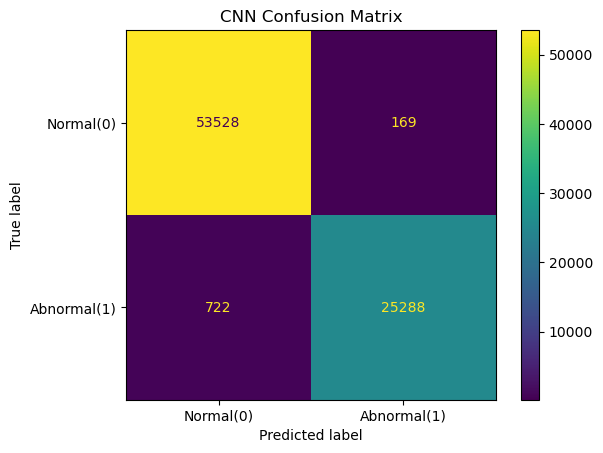

In [13]:

loss, acc, recall = cnn_model.evaluate(X_test_inputs, y_test, verbose=0)
y_pred_prob = cnn_model.predict(X_test_inputs).ravel()
y_pred = (y_pred_prob >= 0.5).astype(int)

acc_val = accuracy_score(y_test, y_pred)
sens_val = recall_score(y_test, y_pred, pos_label=1)
print("\nCNN Evaluation:")
print(f"Loss: {loss:.4f}, Accuracy (Keras): {acc:.4f}, Recall (Keras): {recall:.4f}")
print(f"Accuracy (sklearn): {acc_val:.4f}, Sensitivity (abnormal=1): {sens_val:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=0))
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=['Normal(0)','Abnormal(1)']).plot()
plt.title("CNN Confusion Matrix")
plt.show()

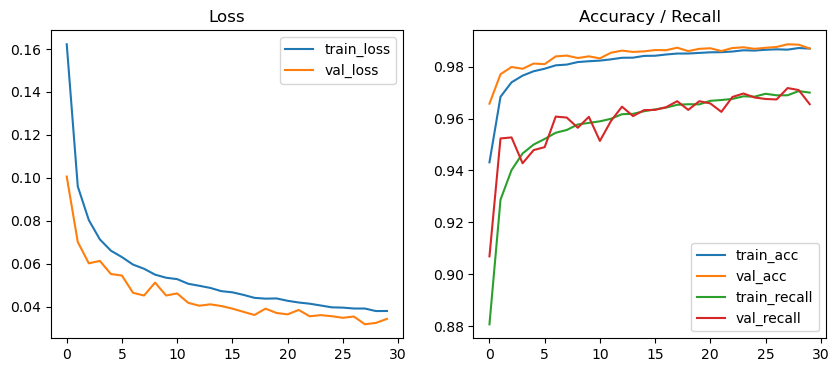

In [14]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history.get('loss', []), label='train_loss')
plt.plot(history.history.get('val_loss', []), label='val_loss')
plt.legend(); plt.title('Loss')
plt.subplot(1,2,2)
plt.plot(history.history.get('accuracy', []), label='train_acc')
plt.plot(history.history.get('val_accuracy', []), label='val_acc')
plt.plot(history.history.get('recall', []), label='train_recall')
plt.plot(history.history.get('val_recall', []), label='val_recall')
plt.legend(); plt.title('Accuracy / Recall')
plt.show()

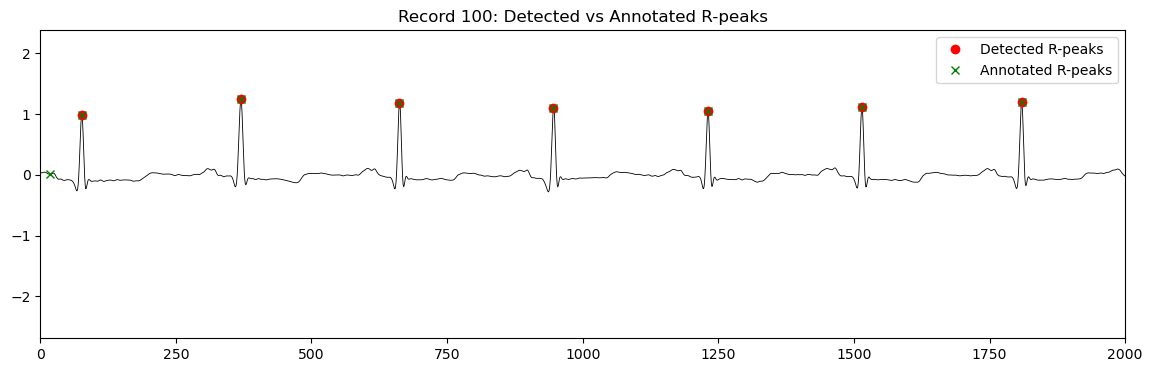

In [15]:

rec0 = files[0].split('.')[0]
rec0_path = os.path.join(data_folder, rec0)
try:
    record0 = wfdb.rdrecord(rec0_path)
    ann0 = wfdb.rdann(rec0_path, 'atr')
    raw0 = record0.p_signal[:,0].astype(float)
    try:
        sig0 = bandpass_filter(raw0, low=0.5, high=40, fs=fs, order=4)
    except Exception:
        sig0 = raw0
    try:
        sig0 = wavelet_denoise(sig0, wavelet=wavelet_name, level=3)
    except Exception:
        pass
    detected = detect_r_peaks(sig0, fs=fs, distance_sec=0.2)
    truep = ann0.sample
    plt.figure(figsize=(14,4))
    plt.plot(sig0, color='black', linewidth=0.6)
    plt.plot(detected, sig0[detected], 'ro', label='Detected R-peaks')
    plt.plot(truep, sig0[truep], 'gx', label='Annotated R-peaks')
    plt.xlim(0,2000)
    plt.legend(); plt.title(f"Record {rec0}: Detected vs Annotated R-peaks"); plt.show()
except Exception as e:
    print("Could not plot example record:", e)

In [16]:

print("\nFINAL SUMMARY:")
print("Total beats:", beats.shape[0])
print("Label counts:", Counter(labels))
print(f"Test accuracy: {acc_val:.4f}, Test sensitivity (abnormal): {sens_val:.4f}")


FINAL SUMMARY:
Total beats: 398532
Label counts: Counter({np.int64(0): 268482, np.int64(1): 130050})
Test accuracy: 0.9888, Test sensitivity (abnormal): 0.9722
